# Using FakeBERT Architecture for Sequence Classification

[Original FakeBERT Paper](https://link.springer.com/content/pdf/10.1007/s11042-020-10183-2.pdf)

FakeBERT Architecture:

![FakeBERT](fakebert.PNG "FakeBERT Architecture")

Summary:

Questions:
* Do we need to split train/test when we load the csv files? I think this should happen in DataLoader
** I would say yes we should have train/validate/test csv files so we can separate our concerns one time and the huggingface library has a useful way to grab data by type in separate CSVs - Megan
* Do we really need a main.py? This could probably be in the notebook
** I agree - Megan


TODO:
- (SKIP) Create config.xml files in config folder and load them into the notebook via the method used in assignments

- Save preprocessed code with the regex (cleaning out newspaper meta data and removing sequences below certain sizze) into data folder so it can be tokenized (test.csv, train.csv, validation.csv)

- (DONE) (for now, run again with preprocessed data files)Run tokenizer code ONCE and save to pickle (to spare the 10 minute runtime every time this notebook loads)

- (DONE) Pull BertModel out of this notebook and use the sources/models/FakeBert.py

- Look at adding the BERT embedding to the nn.Module with the gradients? (maybe why accuracy is not good right now, since it isn't in computation graph?)

- Create a new sources/models/BertLinear.py with a simple nn.Module to turn the embeddings into a linear layer

- Clean the commented out code


In [41]:
# Mount into drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# This is the location of the root directory (on github it would be cs7643-project)
# Yours might look different - Megan
root = '/content/drive/MyDrive/CS7643/Project'

In [43]:
# Detect PY file updates and reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
#%cd drive/MyDrive/Colab\ Notebooks/dl_project
import os
os.chdir(root)
%pwd

'/content/drive/MyDrive/CS7643/Project'

In [45]:
%ls

data/       experiments/  proposal/     README.md  Tutorials
dataset.py  notebooks/    __pycache__/  source/    untitled


### Installations

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
#!pip install -r 'requirements.txt'
!pip install -r 'notebooks/requirement.txt'

In [48]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from torch.optim import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from platform import python_version

In [49]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.13
pandas==1.3.5
numpy==1.21.5
torch==1.10.0+cu111
sklearn==1.0.2
transformers==4.18.0
matplotlib==3.2.2


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

device(type='cuda')

### Parameters (Pre-Model/Experiment)


In [51]:
# inputs
train_fp = 'train.csv'
test_fp = 'test.csv'
pretrained_fp = 'bert-base-uncased'
MAX_LENGTH = 64
PICKLED_TOKENIZER = 'source/dataloader/tokenized64_20220417-210111.p'

### Load CSV Files 
Question (4/16/22) - This may not be necessary. Can the data be preprocessed and saved to train/test locations for use by the get_data.py I created? -Megan

In [ ]:
train = pd.read_csv(train_fp, usecols=['text', 'label'])
test = pd.read_csv(test_fp, usecols=['text', 'label'])
df = pd.concat([train, test], ignore_index=True)
df.head()

In [ ]:
print(f'full data: {df.shape[0]} rows, {df.shape[1]} features')

In [ ]:
# target skew?
# 0 = fake news
# 1 = true news
val_cnts = df.label.value_counts().to_frame(name='total')
val_cnts.loc[:,'percent'] = np.round(val_cnts['total'] / df.shape[0], 4)
val_cnts

In [ ]:
# what text lengths (# characters)?
print('*** text characters ***')
print(f'avg length: {df.text.str.len().mean():0.2f}')
print(f'median length: {df.text.str.len().median()}')
print(f'min length: {df.text.str.len().min():0.2f}')
print(f'max length: {df.text.str.len().max():0.2f}')

In [ ]:
# what text lengths (# words)?
print('*** text words ***')
print(f'avg length: {df.text.str.split().str.len().mean():0.2f}')
print(f'median length: {df.text.str.split().str.len().median()}')
print(f'min length: {df.text.str.split().str.len().min():0.2f}')
print(f'max length: {df.text.str.split().str.len().max():0.2f}')

### Preprocess Data
Question (4/16/22) - This preprocess code can be moved into the source/dataloader folder and done ONCE to generate our Train.csv, Test.csv, and Validation.csv files with proper updates -Megan 

In [ ]:
# remove rows with fewer than 150 characters
min_chars = 150
df = df[df.text.str.len() > min_chars]
df.text.str.len().describe()

In [ ]:
# clip first 30 characters to eliminate location and source information
clip_idx = 30 # replace with regex function
df.text = df.text.str[clip_idx:] # replace with regex function
# df = clip_loc_and_source_info(df) # use function with regex to remove source and location info
df.head()

In [ ]:
s = 'My mother made me an omlette.'

max_words = 3
def clip_text_middle(orig_txt, max_words):
    assert max_words > 1, 'max_words must be > 1'
    new = orig_txt.split()
    while len(new) > max_words:
      new = new[1:-1]
    return new

clip_text_middle(s, 4)

In [ ]:
def clip_text(df, text_column, max_words, method='remove'):
    assert max_words > 1, 'max_words must be > 1'
    assert method in ['remove', 'clip_start', 'clip_end', 'clip_middle'], 'method must be remove, clip_start, clip_end, or clip_middle'
    if method == 'remove':
        return df[df[text_column].str.split().str.len() < max_words]
    elif method == 'clip_start':
        df[text_column] = df[text_column].apply(lambda x: x.split()[:max_words])
    elif method == 'clip_end':
        df[text_column] = df[text_column].apply(lambda x: x.split()[-max_words:])
    elif method == 'clip_middle':
        def clip_text_middle(orig_txt, max_wds):
            new = orig_txt.split()
            while len(new) > max_wds:
                new = new[1:-1]
            return new
        df[text_column] = df[text_column].apply(lambda x: clip_text_middle(x, max_words))
    return df

In [ ]:
# only include file notes less than 500 words
# may try different methods
print(f'original # rows: {df.shape[0]}')
max_words = 500
method = 'remove'
# df = clip_text(df, 'text', max_words=max_words, method='method') # can just leave this line, change method
df = df[df.text.str.split().str.len() < max_words] # exclude samples with > max_words
print(f'clipped data: {df.shape[0]} rows')

In [ ]:
# recheck data skew
val_cnts = df.label.value_counts().to_frame(name='total')
val_cnts.loc[:,'percent'] = np.round(val_cnts['total'] / df.shape[0], 4)
val_cnts

In [ ]:
df.text.str.split().str.len().describe()

In [ ]:
df.head()

In [ ]:
print(f'processed data: {df.shape[0]} rows, {df.shape[1]} features')

### Sample Data

Question (4/16/22) - This sampling code may no longer be needed as we can batch the preprocessed code in entirety. 

In [ ]:
# start with smaller sample
# samp_pct = 0.1
# samp = df.sample(frac=samp_pct)
samp_size = 1000
samp = df.sample(n=samp_size)
samp.shape

In [ ]:
# recheck data skew
val_cnts = samp.label.value_counts().to_frame(name='total')
val_cnts.loc[:,'percent'] = np.round(val_cnts['total'] / samp.shape[0], 4)
val_cnts

### Get dataset, Bert tokens from preprocessed files (data/test.csv, data/train.csv)
Question (4/16/22) - After the preprocess code is completed, can we save the FINAL test, train, validation csv files in the data folder so they can be consumed by my get_data.py berty_data class? - Megan

TODO: When the preprocess code is done, the tokenizer only has to be run once and the resulting torch tensors can be saved. Add an 'if exists' check on the pickled token file to restore it from save rather than go through the 10 minute process of tokenizing each time we run this.

In [52]:
'''
Get the preprocess data from data folder and tokenize and retrieve all data (train, test, validation)
'''
from source.dataloader.get_data import bert_data
import pickle

# Try and skip the tokenizer step if a tokenizer file is set already
# Make sure the tokenizer you are using has the MAX_LENGTH equal to the parameter set
if PICKLED_TOKENIZER is not None:
  data_tokens =  pickle.load( open(PICKLED_TOKENIZER, 'rb'))
else:
  data_tokens = None

bert_data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'train.csv',\
                      test_file = 'test.csv',\
                      val_file = None,\
                      tokenizer_type = pretrained_fp,\
                      data_tokens = data_tokens)

# FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
data_tokenized = bert_data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

# Pickle the tokenized results (if new) to a file
if PICKLED_TOKENIZER is None:
  timestr = time.strftime("%Y%m%d-%H%M%S")
  pickle.dump( data_tokenized, open( "source/dataloader/tokenized" + str(MAX_LENGTH) + '_' + timestr + ".p", 'wb'))

Using custom data configuration data-cf9ebd5eebbe0a50
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-cf9ebd5eebbe0a50/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/2 [00:00<?, ?it/s]

skipping tokenize step and loading saved tokens...


In [53]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35918
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8980
    })
})

In [54]:
# Get train, validation inputs/labels from data_tokenized
train_inputs = data_tokenized['train']['input_ids'] 
val_inputs = data_tokenized['test']['input_ids']
train_labels = data_tokenized['train']['label']
val_labels = data_tokenized['test']['label']

In [55]:
train_dataloader, val_dataloader = bert_data.get_data_loader(train_inputs, val_inputs, train_labels, val_labels)

### get embeddings using BERT

Each file note becomes a 2D tensor:
* Each row is a token or subtoken in the sequence
* Each column is a value in the embedding (vector) for that token

In [56]:
bert_model = BertModel.from_pretrained(pretrained_fp).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Parameters (Model)

In [57]:
BATCH_SIZE = 64
N_SEQUENCES = data_tokenized['train'].shape[0]
NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, 768) # The num_tokens comes from max_length in tokens
# N_SEQUENCES = 500
# NUM_TOKENS = 50
# EMBEDDING_SIZE = 512
# FILTER_SIZES = [2, 3, 4]
# NUM_FILTERS = [3, 3, 3]
FILTER_SIZES = [MAX_LENGTH, MAX_LENGTH, MAX_LENGTH]
NUM_FILTERS = [3, 4, 5]
NUM_CLASSES = 2
DROPOUT = 0.2
LR = 0.1

### build cnn for classification

In [ ]:
# https://chriskhanhtran.github.io/posts/cnn-sentence-classification/

In [24]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')

    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
# This was moved into the get_data.py call above
'''
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def get_data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=64):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader
'''

In [ ]:
# This was moved into the get_data.py call above
'''
from sklearn.model_selection import train_test_split

# Train Test Split
# train_inputs, val_inputs, train_labels, val_labels = train_test_split(
#     X, labels, test_size=0.1, random_state=42)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(bert_embeddings, bert_labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = get_data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=BATCH_SIZE)
'''

In [25]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


In [26]:
# This was moved to source/models/FakeBERT.py
'''
class FakeBERTCNN(nn.Module):
    # def __init__(self, pretrained_embedding, emb_dim, filter_sizes=[3, 4, 5], num_filters=[100, 100, 100], num_classes=2, dropout_p=0.2):
    def __init__(self, emb_dim, filter_sizes=[3, 4, 5], num_filters=[100, 100, 100], num_classes=2, dropout_p=0.2):
        super(FakeBERTCNN, self).__init__()

        # CNN
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=emb_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc1 = nn.Linear(np.sum(num_filters), num_classes)

        # # add parameters for these layers
        # self.conv1d1 = nn.Conv1d()
        # self.pool1 = nn.MaxPool1d()
        # self.conv1d2 = nn.Conv1d()
        # self.pool2 = nn.MaxPool1d()
        # self.flat = nn.Flatten()
        # self.fc2 = nn.Linear()
        # self.fc3 = nn.Linear()

        self.dropout = nn.Dropout(p=dropout_p)
        self.relu = nn.ReLU()

    # def forward(self, input_ids):
    def forward(self, x_embed):

            # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
            # Output shape: (b, embed_dim, max_len)
            x_reshaped = x_embed.permute(0, 2, 1)

            # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
            x_conv_list = [self.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

            # Max pooling. Output shape: (b, num_filters[i], 1)
            x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
                for x_conv in x_conv_list]
            
            # Concatenate x_pool_list to feed the fully connected layer.
            # Output shape: (b, sum(num_filters))
            x_fc1 = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                            dim=1)
            
            # Compute logits. Output shape: (b, n_classes)
            logits = self.fc1(self.dropout(x_fc1))

            return logits
'''

In [27]:
# def initialize_model(pretrained_embedding, embed_dim, filter_sizes, num_filters,
#                     num_classes, dropout=0.2, learning_rate=0.01):

# This was moved to FakeBERT file since it is initialize code for FakeBERT Specifically
'''
def initialize_model(embed_dim, filter_sizes, num_filters, num_classes,
                     dropout=0.2, learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = FakeBERTCNN(emb_dim=embed_dim,
                            filter_sizes=filter_sizes,
                            num_filters=num_filters,
                            num_classes=num_classes,
                            dropout_p=dropout)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    # optimizer = Adadelta(cnn_model.parameters(), lr=learning_rate, rho=0.95)
    optimizer = Adam(cnn_model.parameters(), lr=learning_rate)

    return cnn_model, optimizer
'''

### run training data through BERT and CNN



In [ ]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

'''
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=5):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {\
    'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()
        progress_bar = tqdm(train_dataloader, ascii=True)

        for step, batch in enumerate(progress_bar):
          # Load batch to GPU
          b_input_ids, b_labels = tuple(t.to(device) for t in batch)

          # Get embeddings for current batch
          with torch.no_grad():
            embeddings = bert_model(b_input_ids.to(device))[0]

          # Zero out any previously calculated gradients
          model.zero_grad()

          # Perform a forward pass. This will return logits.
          logits = model(embeddings)

          # Compute loss and accumulate the loss values
          loss = loss_fn(logits, b_labels)
          total_loss += loss.item()

          # Perform a backward pass to calculate gradients
          loss.backward()

          # Update parameters
          optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {\
            val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Get embeddings for current batch
        with torch.no_grad():
            embeddings = bert_model(b_input_ids.to(device))[0]

        # Compute logits
        with torch.no_grad():
            logits = model(embeddings)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy
'''

##Example Experiment

Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   1    |   1.712352   |   51.85   |  0.698786  |   47.23   |   90.74  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   2    |   0.519138   |   71.13   |  0.715271  |   47.23   |   90.61  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   3    |   0.696640   |   50.61   |  0.692396  |   52.77   |   90.51  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   4    |   0.695191   |   50.87   |  0.692121  |   52.77   |   90.54  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   5    |   0.694650   |   50.68   |  0.692376  |   52.77   |   90.52  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   6    |   0.694544   |   50.98   |  0.691627  |   52.77   |   90.94  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   7    |   0.694435   |   51.00   |  0.698107  |   47.23   |   91.06  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   8    |   0.695593   |   50.92   |  0.693497  |   47.23   |   90.69  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

   9    |   0.694211   |   51.29   |  0.694431  |   47.23   |   90.44  


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  10    |   0.695572   |   50.94   |  0.700661  |   47.23   |   90.48  


Training complete! Best accuracy: 52.77%.
epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [1.71235205 0.5191383  0.69664029 0.69519099 0.69465044 0.69454424
 0.69443535 0.69559262 0.69421071 0.69557224] 
val_loss: [0.69878628 0.71527144 0.69239611 0.69212082 0.69237617 0.69162682
 0.69810653 0.69349742 0.69443082 0.7006605 ]


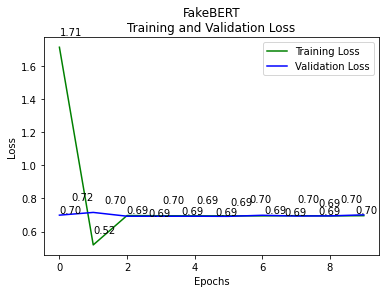

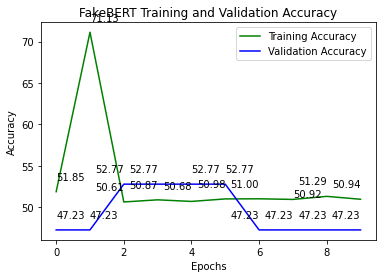

In [92]:
from source import train
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.plot import experiment_plot

# Parameters
BATCH_SIZE = 64
N_SEQUENCES = data_tokenized['train'].shape[0]
NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, 768) # The num_tokens comes from max_length in tokens
# N_SEQUENCES = 500
# NUM_TOKENS = 50
# EMBEDDING_SIZE = 512
# FILTER_SIZES = [2, 3, 4]
# NUM_FILTERS = [3, 3, 3]
FILTER_SIZES = [MAX_LENGTH, MAX_LENGTH, MAX_LENGTH]
NUM_FILTERS = [3, 4, 5]
NUM_CLASSES = 2
DROPOUT = 0.2
LR = 0.1

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

set_seed(42)
cnn_bert, optimizer = initialize_model(device, embed_dim=EMBEDDING_SIZE, filter_sizes=FILTER_SIZES,
                                       num_filters=NUM_FILTERS, num_classes=NUM_CLASSES,
                                       learning_rate=LR, dropout=DROPOUT)
results = train.train(emb_model = bert_model, \
            model = cnn_bert,\
            loss_fn = loss_fn,\
            optimizer = optimizer,\
            train_dataloader = train_dataloader,\
            val_dataloader = val_dataloader,\
            epochs=10)

plot_runner = experiment_plot(results = results,\
                              save_name = "BERT" + '-' \
                                        + 'SEQ' + str(MAX_LENGTH)\
                                        + '-LR' + str(LR)\
                                        + '-DO' + str(DROPOUT)\
                                        + '-BS' + str(BATCH_SIZE),
                              save_path = "experiments/figures/",\
                              append_time = True
                              )
plot_runner.plot(title_prepend = "FakeBERT",\
                 include_points = True)

epochs: [0. 1. 2.] 
train_loss: [1.71235205 0.5191383  0.69664029] 
val_loss: [0.69878628 0.71527144 0.69239611]


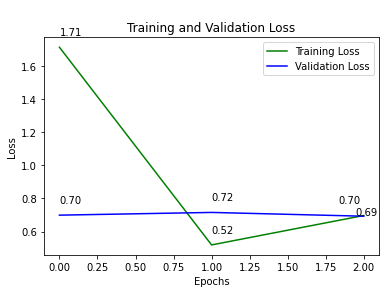

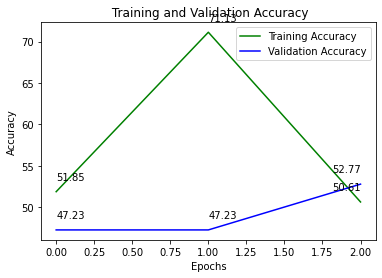

In [84]:
from source.plot import experiment_plot
plot_runner = experiment_plot(results = results)
plot_runner.plot()

In [82]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=7e2d3645310066b6d8a914d01d295a7a5218050cbb95d7c4150122c16915583e
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


### evaluate model performance on test data

In [ ]:
evaluate(cnn_bert, val_dataloader)

### References

https://romanorac.github.io/machine/learning/2019/12/02/identifying-hate-speech-with-bert-and-cnn.html